# Notebook per l'addestramento della rete convoluzionale per la regressione lineare

## Dataset ScenicOrNot


Si preparano innanzitutto gli array di features e di target, ridimensionando le immagini in 96x96

In [1]:
import numpy as np

features_files = [
    '/kaggle/input/scenicornot/array_immagini224_completo11voti1.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti2.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti3.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti4.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti5.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti6.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti7.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti8.npy',
]
votes_files = [
    '/kaggle/input/scenicornot/array_voti_completo11voti1.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti2.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti3.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti4.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti5.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti6.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti7.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti8.npy',
]

features = []
votes = []

for features_file, votes_file in zip(features_files, votes_files):
    features_array = np.load(features_file, allow_pickle=True)
    votes_array = np.load(votes_file, allow_pickle=True)
    
    features.append(features_array)
    votes.append(votes_array)
    
    # Elimina gli array singoli
    del features_array, votes_array

# Concatena gli array
features = np.concatenate(features, axis=0)
votes = np.concatenate(votes, axis=0)

In [2]:
# il dataset completo concatenato contiene 22472 immagini (tutte quelle che hanno ricevuto più di 11 voti)

print(features.shape, votes.shape)

(22472, 224, 224, 3) (22472, 10)


In [3]:
# ridimensionamento immagini per velocizzare addestramento, si usano immagini 96x96

import tensorflow as tf

features_red = []

for i in range(len(features)):
    features_red.append(tf.image.resize(features[i,:,:,:], [96,96]))
features = np.array(features_red)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# riduzione dei valori di pixel tra 0 e 1

features  = features/255

Si separa ora il dataset nei subset di addestramento, validazione e test


In [5]:
tf.random.set_seed(582) #per riproducibilità

In [6]:
from sklearn.model_selection import train_test_split

trainval_features, test_features, trainval_target, test_target = train_test_split(features, votes, test_size=0.2)

# controllo training set
print('TRAINING SET:\t',trainval_features.shape)

# controllo test set
print('TEST SET:\t',test_features.shape)

# validazione

indices = np.arange(len(trainval_features))

train_features, val_features, train_target, val_target = train_test_split(trainval_features, trainval_target, test_size=0.1)

# controllo training set
print('TRAINING SET:\t',train_features.shape)

# controllo validation set
print('VALIDATION SET:\t',val_features.shape)

TRAINING SET:	 (17977, 96, 96, 3)
TEST SET:	 (4495, 96, 96, 3)
TRAINING SET:	 (16179, 96, 96, 3)
VALIDATION SET:	 (1798, 96, 96, 3)


In [7]:
del features, trainval_features

In questi caso la loss sarà basata sui valori medi, pertanto vengono modificati i target in valori medi per ogni immagine

In [8]:
# estrazione delle medie

train_target = tf.reduce_sum(train_target*[1,2,3,4,5,6,7,8,9,10], axis=1)
val_target   = tf.reduce_sum(val_target*[1,2,3,4,5,6,7,8,9,10], axis=1)
test_target  = tf.reduce_sum(test_target*[1,2,3,4,5,6,7,8,9,10], axis=1)

## Modello

In [55]:
#import per keras

from tensorflow import keras
from tensorflow.keras import Model, Input,regularizers

# import per i layers

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Reshape, AvgPool2D, Dropout

#eliminazione backend

keras.backend.clear_session()

In [56]:
#definizione del modello, inputs (96x96x3)

inputs = Input(shape=(96,96,3)) 

#C1
x = Conv2D(filters=16, kernel_size=(7,7), padding='same', strides=(1,1), activation='relu')(inputs)

#S2
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C3
x = Conv2D(filters=24, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu',kernel_regularizer=regularizers.l1(0.001))(x)

#S4
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C5 
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu',kernel_regularizer=regularizers.l1(0.001))(x)

#S6
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C7 
x = Conv2D(filters=120, kernel_size=(3,3), padding='valid', strides=(1,1), activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)

#S8
#x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#c9
#x = Conv2D(filters=256, kernel_size=(3,3), padding='valid', strides=(1,1), activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)

# flatten 
x = Flatten()(x)

#F10 con regolarizzatore l1
x = Dense(84, activation='relu')(x)

#D7
dropout_rate = 0.2  # Tasso di dropout desiderato
x = Dropout(rate=dropout_rate)(x)

# Funzione di trasformazione lineare tra 1 e 10
def custom_activation(x):
    min_value = 1  # Valore minimo 
    max_value = 10  # Valore massimo 
    float_value = 1 + 9 * tf.sigmoid(x)
    return float_value

#output 
outputs = Dense(1, activation=custom_activation)(x)


#modello
model = Model(inputs=inputs, outputs=outputs, name='basic_model')

Qui la loss è una funzione personalizzata per perare proporzionalmente di più gli errori quando questi sono fatti su dati che presentano una media lontana dai valori centrali

In [57]:
# definizione della loss e compilazione

from tensorflow.keras import optimizers, metrics

def weighted_loss(y_true, y_pred):
    weights=1+tf.exp((tf.abs(y_true-4)))
    loss=tf.reduce_mean(tf.square(y_true-y_pred)*weights)
    return loss

def macro_accuracy(y_true, y_pred):
    true_macroclass=tf.where(y_true < 4, tf.ones_like(y_true), tf.where(y_true < 7, 2 * tf.ones_like(y_true), 3 * tf.ones_like(y_true)))
    pred_macroclass=tf.where(y_pred < 4, tf.ones_like(y_pred), tf.where(y_pred < 7, 2 * tf.ones_like(y_pred), 3 * tf.ones_like(y_pred)))
    # Calcola l'accuratezza delle predizioni sulle macroclassi
    accuracy = tf.reduce_mean(tf.cast(tf.equal(true_macroclass, pred_macroclass), tf.float32))
    return accuracy


In [58]:
from keras.callbacks import Callback
from tensorflow.keras import backend as K
from keras.optimizers import RMSprop, Adam

class LearningRateReducer(Callback):
    def __init__(self, initial_lr, reduce_factor, reduce_freq):
        super(LearningRateReducer, self).__init__()
        self.initial_lr = initial_lr
        self.reduce_factor = reduce_factor
        self.reduce_freq = reduce_freq

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.reduce_freq == 0 and epoch != 0:
            lr = K.get_value(self.model.optimizer.lr)
            new_lr = lr * self.reduce_factor
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f"Learning rate reduced to: {new_lr}")

# Definire i parametri
learning_rate = 0.001
reduce_factor = 0.5
reduce_freq = 4

# Creare l'istanza della callback personalizzata
lr_reducer = LearningRateReducer(initial_lr=learning_rate, reduce_factor=reduce_factor, reduce_freq=reduce_freq)


model.compile(
    loss=weighted_loss,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),#optimizers.SGD(learning_rate=learning_rate),
    metrics=[metrics.mean_absolute_error, metrics.mean_squared_error]
)


# Allenamento del modello con la callback personalizzata
history = model.fit(
    train_features,
    train_target,
    epochs=20,
    batch_size=64,
    validation_data=(val_features, val_target),
    verbose=1,
    callbacks=[lr_reducer]
)

Epoch 1/20
253/253 [==============================] - 182s 713ms/step - loss: 36.1801 - mean_absolute_error: 1.4771 - mean_squared_error: 3.3630 - val_loss: 27.9400 - val_mean_absolute_error: 1.4494 - val_mean_squared_error: 3.3069
Epoch 2/20
253/253 [==============================] - 182s 720ms/step - loss: 26.5431 - mean_absolute_error: 1.3724 - mean_squared_error: 2.9583 - val_loss: 27.5767 - val_mean_absolute_error: 1.3479 - val_mean_squared_error: 2.7841
Epoch 3/20
253/253 [==============================] - 181s 717ms/step - loss: 23.5590 - mean_absolute_error: 1.3222 - mean_squared_error: 2.7522 - val_loss: 22.4981 - val_mean_absolute_error: 1.3449 - val_mean_squared_error: 2.8567
Epoch 4/20
253/253 [==============================] - 180s 712ms/step - loss: 21.6040 - mean_absolute_error: 1.2664 - mean_squared_error: 2.5556 - val_loss: 22.9342 - val_mean_absolute_error: 1.1747 - val_mean_squared_error: 2.2111
Learning rate reduced to: 0.0005000000237487257
Epoch 5/20
253/253 [====

## Valutazione del training

In [59]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_32/364958460.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


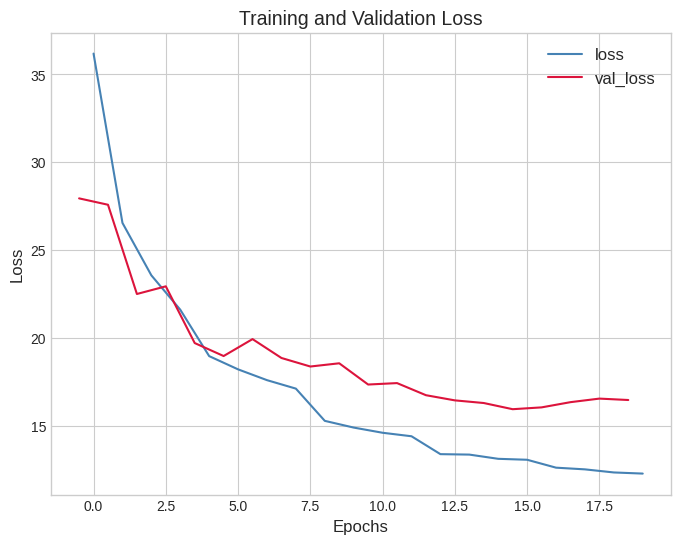

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

metrics_to_plot = ['loss', 'val_loss']  # Seleziona le metriche da plottare

for metric in metrics_to_plot:
    # Sottrai 0.5 dall'epoca per la visualizzazione più centrata
    if metric.startswith('val_'):
        ax.plot(np.array(history.epoch) - 0.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)

ax.grid(True)
# Colori dei grafici
colors = ['steelblue', 'crimson', 'orange', 'purple']
for i, line in enumerate(ax.lines):
    line.set_color(colors[i % len(colors)])

ax.legend(fontsize=12)

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss', fontsize=14)

plt.savefig('loss_reg.png')

plt.show()

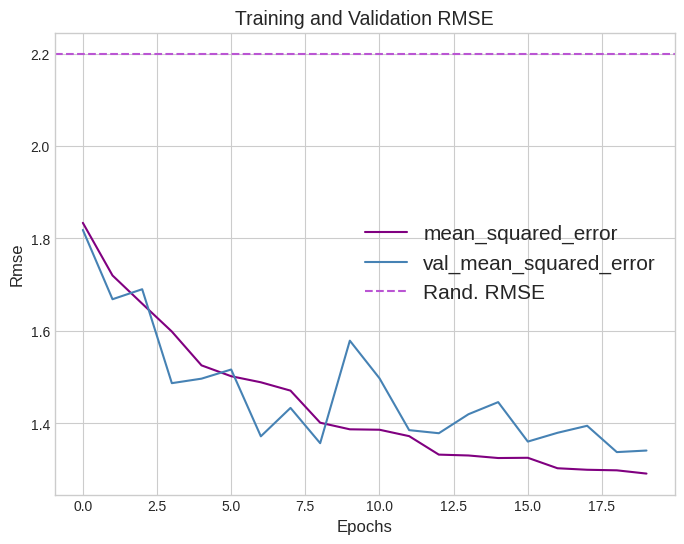

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))

metrics_to_plot = [metric for metric in history.history if metric not in ['loss', 'val_loss', 'mean_absolute_error', 'val_mean_absolute_error']]

for metric in metrics_to_plot:
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch) - 0.5, np.rqrt(history.history[metric]), label=metric)
    else:
        ax.plot(history.epoch, np.sqrt(history.history[metric]), label=metric)

ax.axhline(y=2.2, linestyle='--', label='Rand. RMSE')  # Aggiungi una linea orizzontale a 1
ax.grid(True)
ax.legend(fontsize=10)

# Colori dei grafici
colors = ['purple','steelblue', 'mediumorchid','blue'  ,'orange']
for i, line in enumerate(ax.lines):
    line.set_color(colors[i % len(colors)])

ax.legend(fontsize=15)

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Rmse', fontsize=12)
ax.set_title('Training and Validation RMSE', fontsize=14)

plt.savefig('rmsereg.png')

plt.show()

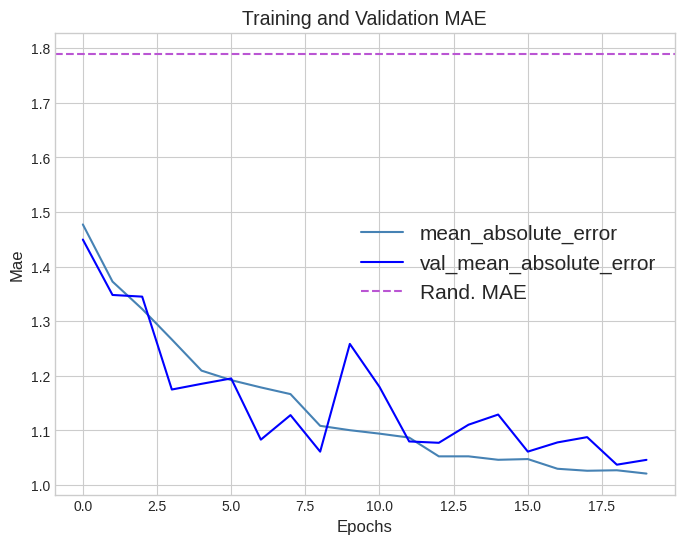

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

metrics_to_plot = [metric for metric in history.history if metric not in ['loss', 'val_loss', 'mean_squared_error', 'val_mean_squared_error']]

for metric in metrics_to_plot:
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch) - 0.5, np.rqrt(history.history[metric]), label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)

ax.axhline(y=1.79, linestyle='--', label='Rand. MAE')  # Aggiungi una linea orizzontale a 1
ax.grid(True)
ax.legend(fontsize=10)

# Colori dei grafici
colors = ['steelblue','blue', 'mediumorchid'  ,'orange']
for i, line in enumerate(ax.lines):
    line.set_color(colors[i % len(colors)])

ax.legend(fontsize=15)

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Mae', fontsize=12)
ax.set_title('Training and Validation MAE', fontsize=14)

plt.savefig('maereg.png')

plt.show()

## Valutazione sul test set

In [64]:
#evaluate model on the test set
test_loss, test_acc, test_mse = model.evaluate(test_features, test_target)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

141/141 [==============================] - 12s 83ms/step - loss: 15.8929 - mean_absolute_error: 1.0319 - mean_squared_error: 1.7233

Test Loss:	 15.892932891845703
Test Accuracy:	 1.0319149494171143


In [65]:
y_test_pred = model.predict(test_features)

141/141 [==============================] - 12s 82ms/step


In [74]:
low_indices = np.argsort(y_test_pred[:,0])[::-1][:10]
top_real_indices=np.argsort(test_target)[::-1][:10]

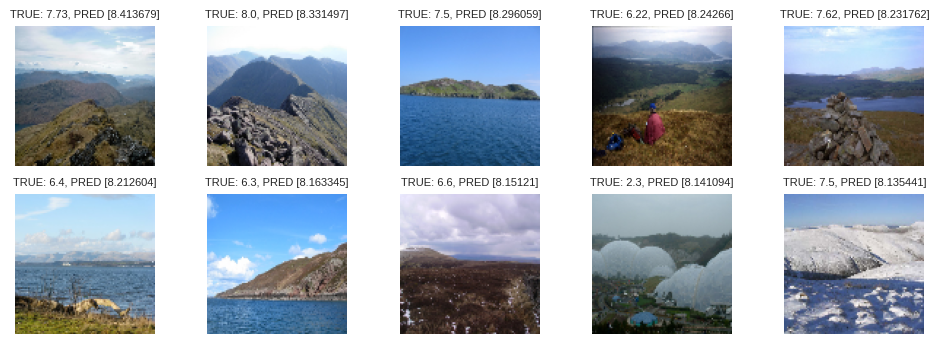

In [70]:
fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = low_indices[i]
    
    ax.imshow(test_features[idx], cmap='gray')
    ax.set_title('TRUE: {}, PRED {}'.format(np.round(test_target[idx],decimals=2), y_test_pred[idx]), fontsize=8)
    ax.axis('off')
    
fig.savefig('10bestreg.png')

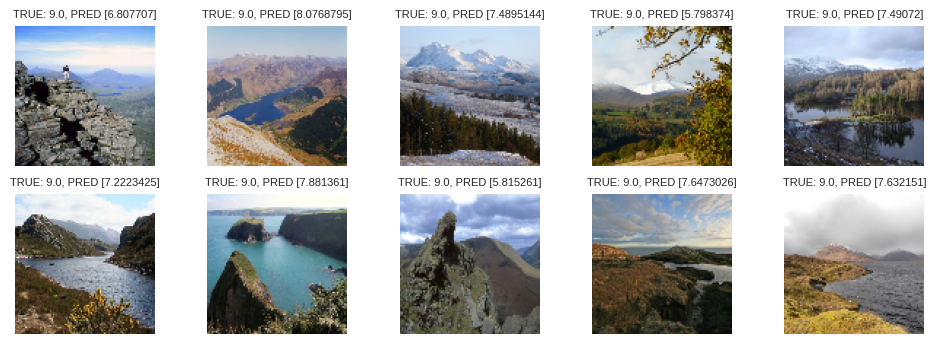

In [75]:
fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = top_real_indices[i]
    
    ax.imshow(test_features[idx], cmap='gray')
    ax.set_title('TRUE: {}, PRED {}'.format(np.round(test_target[idx]), y_test_pred[idx]), fontsize=8)
    ax.axis('off')

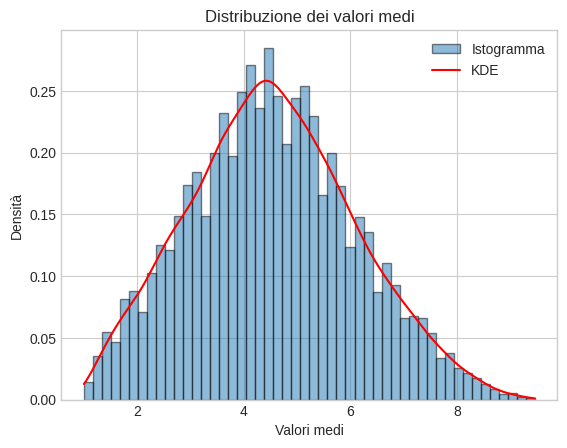

In [76]:
from scipy.stats import gaussian_kde

hist, bin_edges = np.histogram(train_target, bins='auto', density=True)

kde = gaussian_kde(train_target)

x = np.linspace(min(train_target), max(train_target), 1000)

plt.hist(train_target, bins='auto', density=True, alpha=0.5, label='Istogramma', edgecolor='black')

plt.plot(x, kde(x), 'r-', label='KDE')

plt.title('Distribuzione dei valori medi')
plt.xlabel('Valori medi')
plt.ylabel('Densità')

plt.grid(True)

plt.legend()

plt.savefig('distriappreg.png')

plt.show()

In [77]:
# Genera alcuni valori casuali dalla distribuzione approssimata
null_pred = kde.resample(size=len(test_target))

In [78]:
# calcolo frazione di previsioni che distano tra loro più di 

def plot_distance_curve(vec1, vec2):
    distanze = np.abs(vec1 - vec2)
    
    distanze_ordinate = np.sort(distanze)
    frazione = np.arange(1, len(distanze_ordinate) + 1) / len(distanze_ordinate)
    
    plt.plot(distanze_ordinate, frazione)

    indice_90_percento = np.argmax(frazione >= 0.9)
    plt.axvline(x=distanze_ordinate[indice_90_percento], color='r', linestyle='--', label='90%')

    plt.xlabel('Distanza')
    plt.ylabel('Frazione')
    plt.title('Curva della frazione di elementi per distanza')
    


    plt.show()

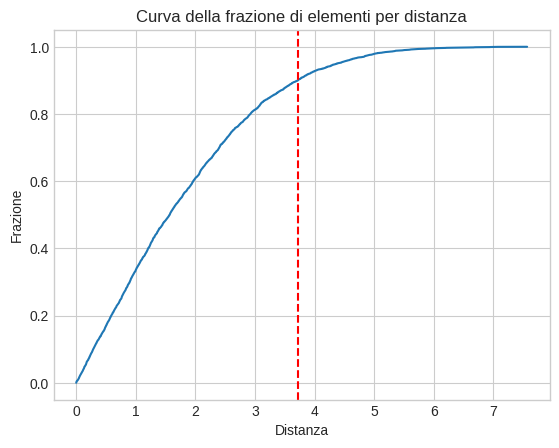

In [79]:
plot_distance_curve(null_pred[0], test_target)

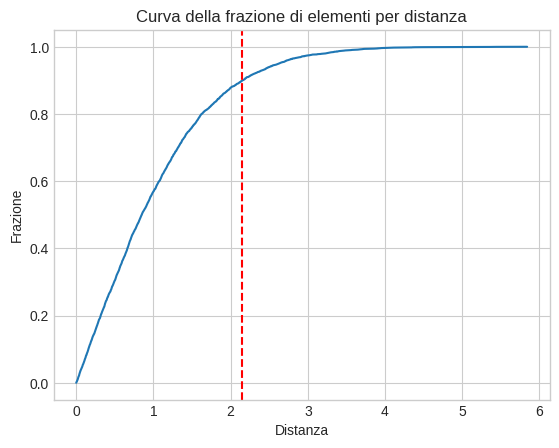

In [80]:
y_pred=np.squeeze(y_test_pred)
plot_distance_curve(y_pred, test_target)

In [81]:
# errore assoluto medio random e della rete

err_random = np.mean(np.abs(null_pred-test_target))
err_rete   = np.mean(np.abs(y_test_pred[:,0]-test_target))

print('errore random {} \nerrore rete {}'.format(err_random,err_rete))

errore random 1.8156444263952152 
errore rete 1.0319149694833747


In [82]:
#miglioramento percentuale

perc_miglioramento = (err_random - err_rete) / err_random * 100
perc_miglioramento

43.16536021691532

In [83]:
# confronto MSE

err_random_2 = np.sqrt(np.mean((null_pred-test_target)**2))
err_rete_2   = np.sqrt(np.mean((y_test_pred[:,0]-test_target)**2))

print('errore random 2 {} \nerrore rete 2 {}'.format(err_random_2,err_rete_2))

errore random 2 2.2501343899801975 
errore rete 2 1.3127269418257512


In [85]:
# riscalamento per renderla confrontabile con l'accuracy

perc_miglioramento_2 = (err_random_2 - err_rete_2) / err_random * 100
perc_miglioramento_2

51.6294619434697